Dataset source: https://www.kaggle.com/datasets/mirichoi0218/insurance?datasetId=13720&sortBy=voteCount

Dataset dictionary:
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

## Utils

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mstats

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, GridSearchCV, LeaveOneOut
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures  

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
np.set_printoptions

<function numpy.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, suppress=None, nanstr=None, infstr=None, formatter=None, sign=None, floatmode=None, *, legacy=None)>

In [2]:
def desc_stat(df, colname):
    mean = df[colname].mean().round(2)
    std = df[colname].std().round(2)
    median = df[colname].median()
    skew = df[colname].skew().round(2)
    
    return mean, std, median, skew

In [3]:
def calculate_ttest(A,B):
    """
    The statistic is calculated as (np.mean(a) - np.mean(b))/se, where se is the standard error. 
    Therefore, the statistic will be positive when the sample mean of a is greater than 
    the sample mean of b and negative when the sample mean of a is less than the sample mean of b.
    """
    shapiro_A = stats.shapiro(A)
    shapiro_B = stats.shapiro(B)
    
    if shapiro_A.pvalue < 0.05 and shapiro_B.pvalue < 0.05:
        result = stats.ttest_ind(A,B)
        print(result)
        if result[1] < 0.05:
            print('Ttest result is statistically significant.')
        else:
            print('Ttest result is NOT statistically significant.')
    else:
        print('Data were not drawn from normal dist - no ttest allowed.')    

In [4]:
filename = '../data/insurance.csv'
insurance = pd.read_csv(filename)

In [5]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
print('Dataset general information:\n')
insurance.info()

Dataset general information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
print(f'Rows: {insurance.shape[0]}\nColumns: {insurance.shape[1]}')

Rows: 1338
Columns: 7


In [8]:
print('Dataset column types:')
print(insurance.dtypes.value_counts())

Dataset column types:
object     3
int64      2
float64    2
dtype: int64


In [9]:
print('Numerical variables:')
display(insurance.describe().T)
print('---------------------------------')
print('Categorical variables:')
insurance.select_dtypes(include=['object']).describe()

Numerical variables:


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


---------------------------------
Categorical variables:


,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [10]:
insurance.duplicated().sum()

1

In [11]:
insurance.drop_duplicates(inplace=True)
insurance.shape

(1337, 7)

## Data types standarization

In [12]:
col_names = insurance.select_dtypes(include=['object']).columns.to_list()

for col in col_names:
    insurance[col] = insurance[col].astype('category')

In [13]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 56.6 KB


## EDA

Mean: 39.22
Std: 14.04
Median:39.0
Skew: 0.05


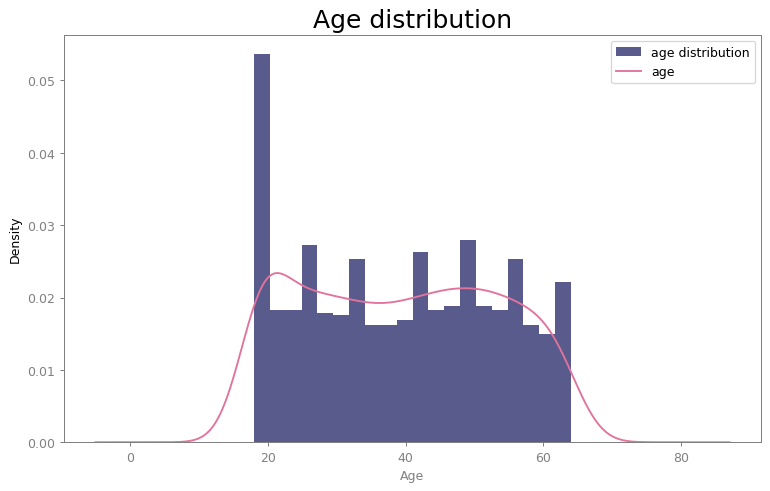

In [14]:
mean, std, median, skew = desc_stat(insurance, 'age')
print(f'Mean: {mean}\nStd: {std}\nMedian:{median}\nSkew: {skew}')

fig, ax = plt.subplots(figsize=(10,6),dpi=90)

ax.hist(insurance['age'], label='age distribution', bins=20, density=True, alpha=0.7, color='#11155C')
insurance['age'].plot(kind='density', color='#E1739D')
ax.set_xlabel('Age',fontsize='medium', color='gray')
ax.set_title('Age distribution', fontsize = 20, color='black')

ax.tick_params('x', colors='gray')
ax.tick_params('y', colors='gray')

ax.spines["top"].set_color("gray")
ax.spines["bottom"].set_color("gray")
ax.spines["left"].set_color("gray")
ax.spines["right"].set_color("gray")

plt.legend()
plt.show()

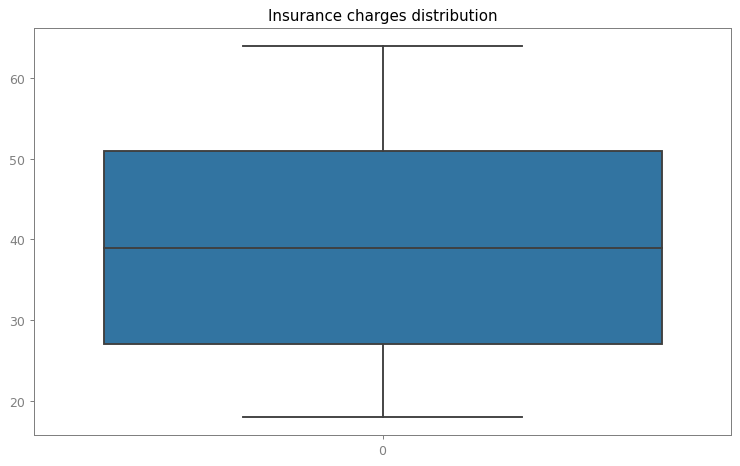

In [15]:
fig, ax = plt.subplots(figsize=(10,6), dpi=90)

sns.boxplot(insurance['age'])

ax.set_title('Insurance charges distribution')
ax.tick_params('x', colors='gray')
ax.tick_params('y', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.show()

Mean: 30.66
Std: 6.1
Median:30.4
Skew: 0.28


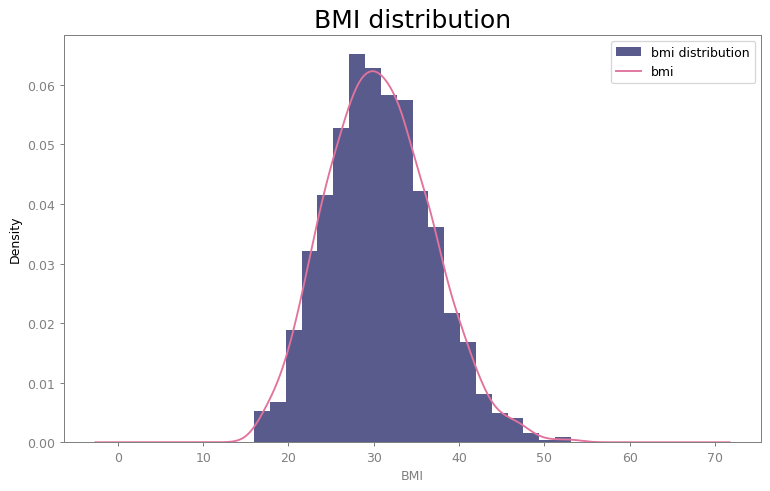

In [16]:
mean, std, median, skew = desc_stat(insurance, 'bmi')
print(f'Mean: {mean}\nStd: {std}\nMedian:{median}\nSkew: {skew}')

fig, ax = plt.subplots(figsize=(10,6), dpi=90)

ax.hist(insurance['bmi'], label='bmi distribution', bins=20, density=True, alpha=0.7, color='#11155C')
insurance['bmi'].plot(kind='density', color='#E1739D')
ax.set_xlabel('BMI',fontsize='medium', color='gray')
ax.set_title('BMI distribution', fontsize = 20, color='black')

ax.tick_params('x', colors='gray')
ax.tick_params('y', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.legend()
plt.show()

Mean: 1.1
Std: 1.21
Median:1.0
Mode:0.0


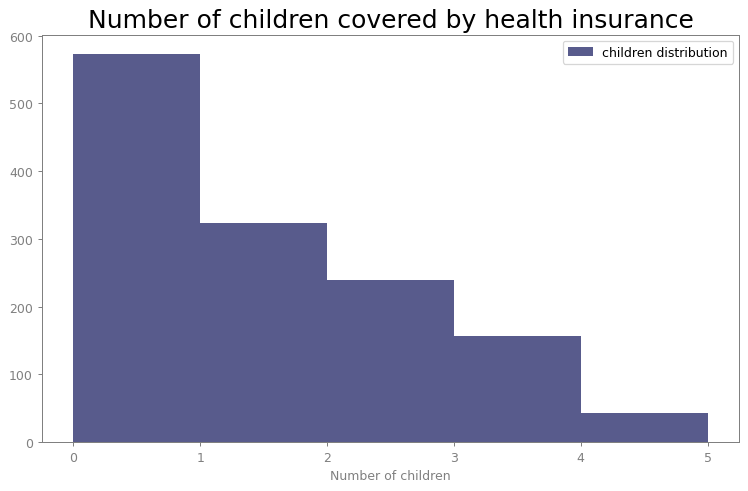

In [17]:
mean, std, median, skew = desc_stat(insurance, 'children')
mode = mstats.mode(insurance['children'])
print(f'Mean: {mean}\nStd: {std}\nMedian:{median}\nMode:{mode[0][0]}')

fig, ax = plt.subplots(figsize=(10,6), dpi=90)
ax.hist(insurance['children'], label='children distribution', bins=insurance['children'].max(), alpha=0.7, color='#11155C')

ax.set_xlabel('Number of children', color='gray', fontsize='medium')
ax.set_title('Number of children covered by health insurance', color='black', fontsize=20)

ax.tick_params('y', colors='gray')
ax.tick_params('x', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.legend()
plt.show()

Mean: 13279.12
Std: 12110.36
Median:9386.1613
Skew: 1.52


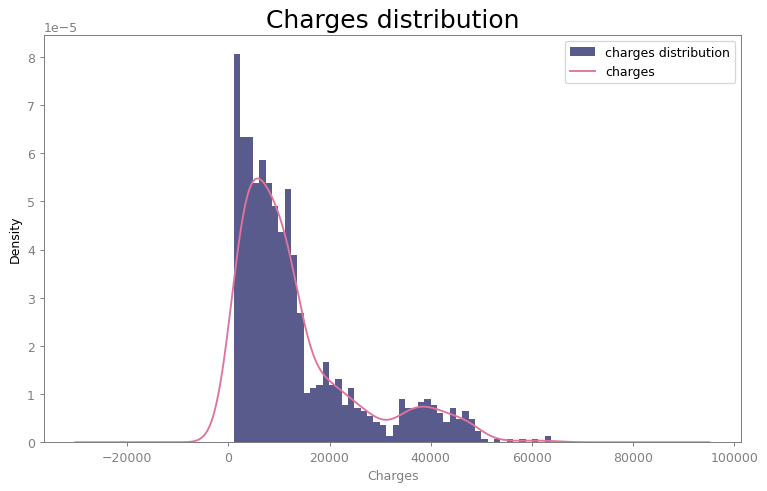

In [18]:
mean, std, median, skew = desc_stat(insurance,'charges')
print(f'Mean: {mean}\nStd: {std}\nMedian:{median}\nSkew: {skew}')
stats.tmean(insurance['charges'])

fig, ax = plt.subplots(figsize=(10,6), dpi=90)
ax.hist(insurance['charges'], label='charges distribution', bins=50, density=True, alpha=0.7, color='#11155C')
insurance['charges'].plot(kind='density', color='#E1739D')

ax.set_xlabel('Charges', fontsize='medium', color='gray')
ax.set_title('Charges distribution', fontsize=20, color='black')

ax.tick_params('x', colors='gray')
ax.tick_params('y', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.legend()
plt.show()

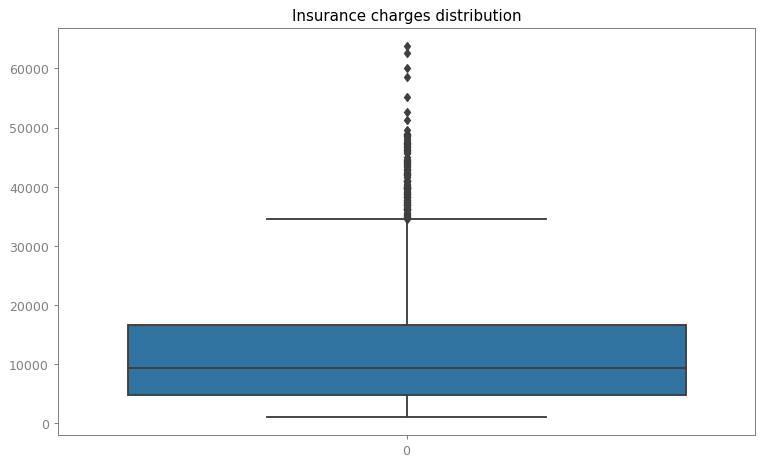

In [19]:
fig, ax = plt.subplots(figsize=(10,6), dpi=90)

sns.boxplot(insurance['charges'])

ax.set_title('Insurance charges distribution')
ax.tick_params('x', colors='gray')
ax.tick_params('y', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.show()

In [20]:
index_to_drop = insurance[insurance['charges']>60000].index
insurance.drop(index=index_to_drop, inplace=True)

Mean: 13169.27
Std: 11899.7
Median:9369.61575
Skew: 1.47


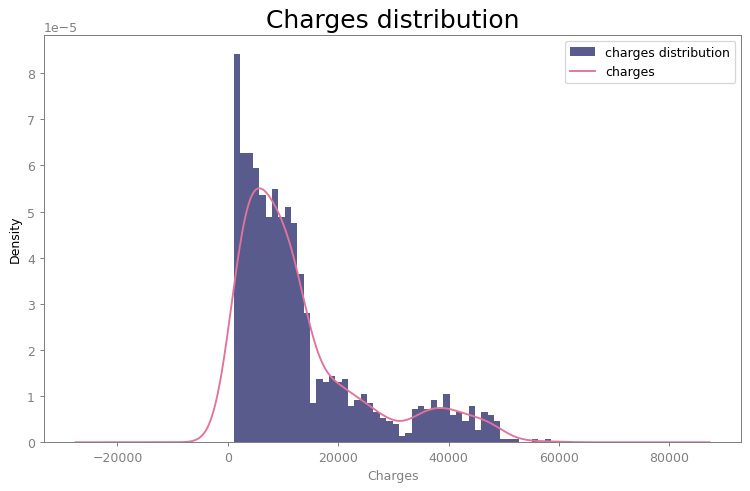

In [21]:
mean, std, median, skew = desc_stat(insurance,'charges')
print(f'Mean: {mean}\nStd: {std}\nMedian:{median}\nSkew: {skew}')
stats.tmean(insurance['charges'])

fig, ax = plt.subplots(figsize=(10,6), dpi=90)
ax.hist(insurance['charges'], label='charges distribution', bins=50, density=True, alpha=0.7, color='#11155C')
insurance['charges'].plot(kind='density', color='#E1739D')

ax.set_xlabel('Charges', fontsize='medium', color='gray')
ax.set_title('Charges distribution', fontsize=20, color='black')

ax.tick_params('x', colors='gray')
ax.tick_params('y', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.legend()
plt.show()

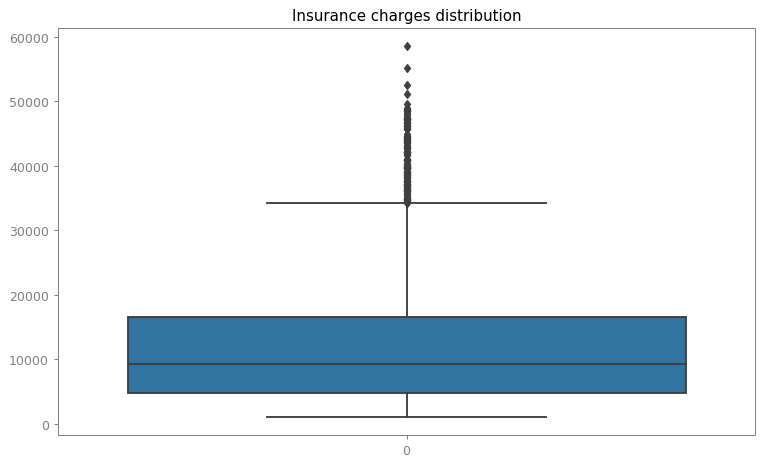

In [22]:
fig, ax = plt.subplots(figsize=(10,6), dpi=90)

sns.boxplot(insurance['charges'])

ax.set_title('Insurance charges distribution')
ax.tick_params('x', colors='gray')
ax.tick_params('y', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.show()

,Total
sex,
female,49.55
male,50.45


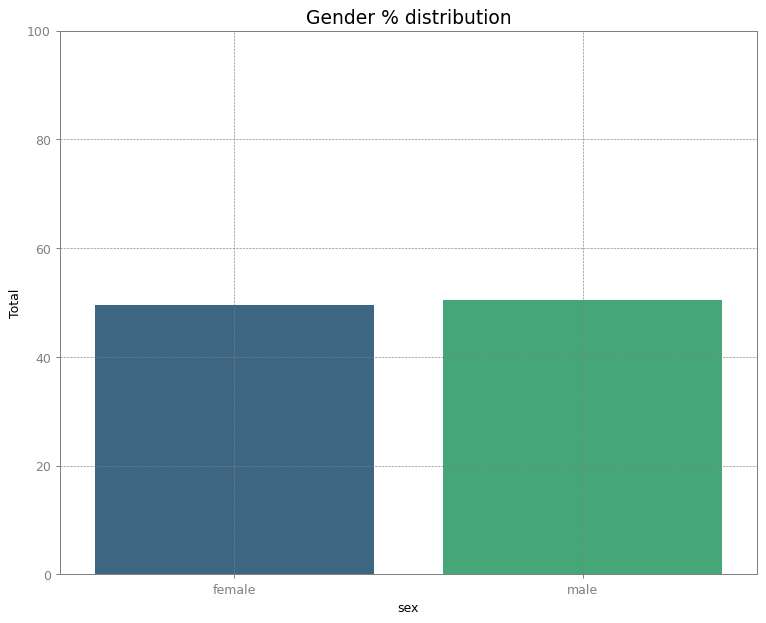

In [23]:
insurance['Total'] = 1
gender = pd.pivot_table(data=insurance, 
                    values='Total',
                    index='sex', aggfunc=np.sum).apply(lambda x:100 * x / float(x.sum())).round(2)
display(gender)

fig, ax = plt.subplots(figsize=(10,8), dpi=90)
sns.barplot(data=gender, x=gender.index, y='Total', palette='viridis')
plt.ylim(0,100)
ax.set_title('Gender % distribution', fontsize=15, color='black')
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)

ax.tick_params('y', colors='gray')
ax.tick_params('x', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.show()

,Total
smoker,
no,79.69
yes,20.31


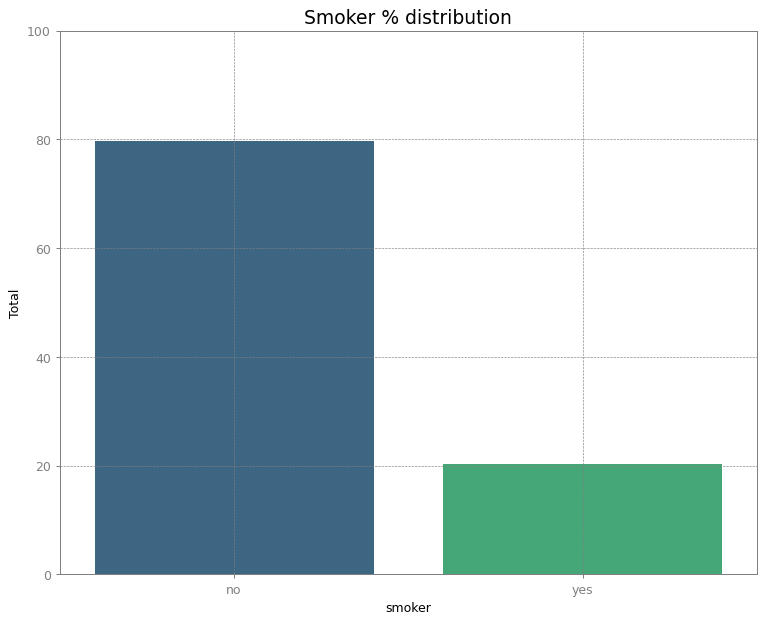

In [24]:
insurance['Total'] = 1
smoker = pd.pivot_table(data=insurance, 
                    values='Total',
                    index='smoker', aggfunc=np.sum).apply(lambda x:100 * x / float(x.sum())).round(2)
display(smoker)

fig, ax = plt.subplots(figsize=(10,8), dpi=90)
sns.barplot(data=smoker, x=smoker.index, y='Total', palette='viridis')
plt.ylim(0,100)
ax.set_title('Smoker % distribution', fontsize=15, color='black')
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)

ax.tick_params('y', colors='gray')
ax.tick_params('x', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.show()

,Total
region,
northeast,24.29
northwest,24.21
southeast,27.14
southwest,24.36


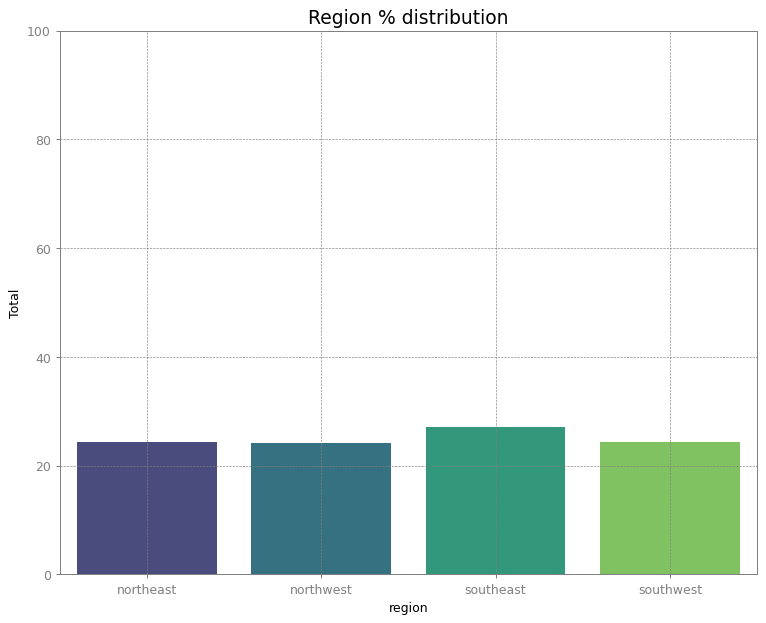

In [25]:
insurance['Total'] = 1
region = pd.pivot_table(data=insurance, 
                    values='Total',
                    index='region', aggfunc=np.sum).apply(lambda x:100 * x / float(x.sum())).round(2)
display(region)

fig, ax = plt.subplots(figsize=(10,8), dpi=90)
sns.barplot(data=region, x=region.index, y='Total', palette='viridis')
plt.ylim(0,100)
ax.set_title('Region % distribution', fontsize=15, color='black')
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)

ax.tick_params('y', colors='gray')
ax.tick_params('x', colors='gray')

ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.show()

### Which features correlate with one another?


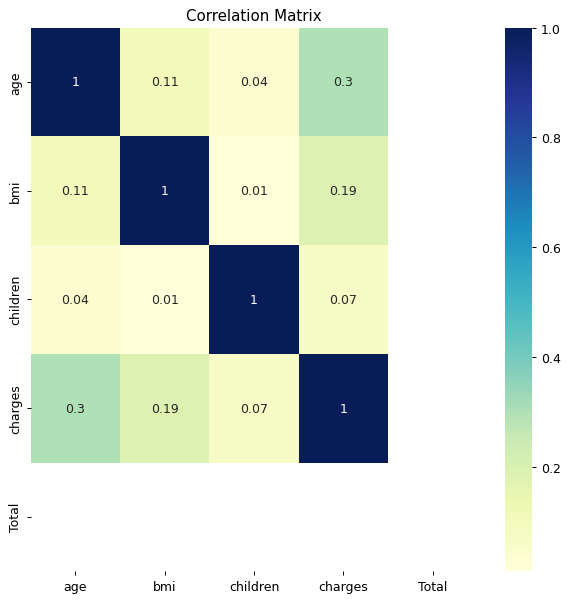

In [26]:
fig, ax = plt.subplots(figsize=(8,8), dpi=90)

sns.heatmap(insurance.corr().round(2), cmap="YlGnBu",annot=True)
ax.set_title('Correlation Matrix')
plt.show()

<AxesSubplot:xlabel='age', ylabel='charges'>

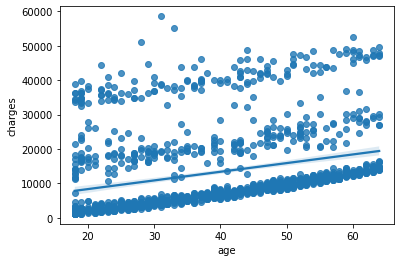

In [27]:
sns.regplot(data=insurance, y=insurance.charges, x=insurance.age)

<AxesSubplot:xlabel='bmi', ylabel='charges'>

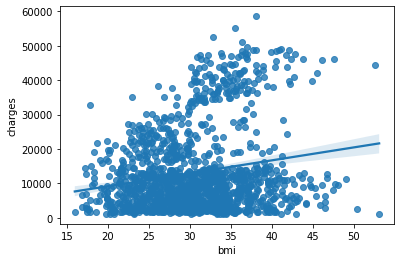

In [28]:
sns.regplot(data=insurance, y=insurance.charges, x=insurance.bmi)

In [29]:
# Smoker vs NonSmoker
smoker_charges = insurance[insurance['smoker']=='yes']['charges']
non_smoker_charges = insurance[insurance['smoker']=='no']['charges']
smoker_bmi = insurance[insurance['smoker']=='yes']['bmi']
non_smoker_bmi = insurance[insurance['smoker']=='no']['bmi']
smoker_children = insurance[insurance['smoker']=='yes']['children']
non_smoker_children = insurance[insurance['smoker']=='no']['children']
smoker_age = insurance[insurance['smoker']=='yes']['age']
non_smoker_age = insurance[insurance['smoker']=='no']['age']

print('Smoker vs Non-Smoker - insurance charges:')
result_smoker_charges = calculate_ttest(smoker_charges,non_smoker_charges)
print('---------------------------------------------------\n')
print('Smoker vs Non-Smoker - bmi:')
result_smoker_bmi= calculate_ttest(smoker_bmi,non_smoker_bmi)
print('---------------------------------------------------\n')
print('Smoker vs Non-Smoker - children:')
result_smoker_children= calculate_ttest(smoker_children,non_smoker_children)
print('---------------------------------------------------\n')
print('Smoker vs Non-Smoker - age:')
result_smoker_age= calculate_ttest(smoker_age,non_smoker_age)
print('---------------------------------------------------\n')

insurance.groupby('smoker').mean().T

Smoker vs Non-Smoker - insurance charges:
Ttest_indResult(statistic=46.60301606560592, pvalue=4.9717154434043376e-282)
Ttest result is statistically significant.
---------------------------------------------------

Smoker vs Non-Smoker - bmi:
Data were not drawn from normal dist - no ttest allowed.
---------------------------------------------------

Smoker vs Non-Smoker - children:
Ttest_indResult(statistic=0.28208509608702315, pvalue=0.7779220822929117)
Ttest result is NOT statistically significant.
---------------------------------------------------

Smoker vs Non-Smoker - age:
Ttest_indResult(statistic=-1.0677510087036046, pvalue=0.285826317893197)
Ttest result is NOT statistically significant.
---------------------------------------------------



smoker,no,yes
age,39.404516,38.383764
bmi,30.651853,30.634170
children,1.091251,1.114391
charges,8440.660307,31717.265025
Total,1.000000,1.000000


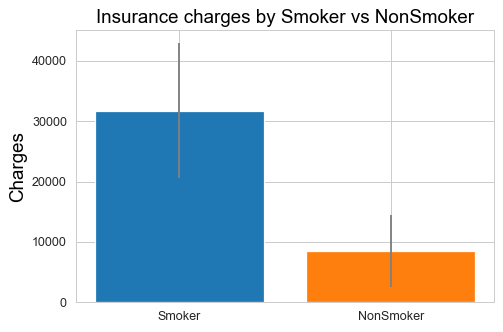

In [38]:
with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Smoker', smoker_charges.mean(), 
           yerr=smoker_charges.std(), ecolor = 'gray')
    ax.bar('NonSmoker', non_smoker_charges.mean(), 
           yerr=non_smoker_charges.std(), ecolor = 'gray')
    ax.set_ylabel('Charges', fontsize=15, color='black')
    plt.title("Insurance charges by Smoker vs NonSmoker", fontsize=15, color='black')
    plt.show()

In [39]:
# Gender
f_charges = insurance[insurance['sex']=='female']['charges']
m_charges = insurance[insurance['sex']=='male']['charges']
f_bmi = insurance[insurance['sex']=='female']['bmi']
m_bmi = insurance[insurance['sex']=='male']['bmi']
f_children = insurance[insurance['sex']=='female']['children']
m_children = insurance[insurance['sex']=='male']['children']
f_age = insurance[insurance['sex']=='female']['age']
m_age = insurance[insurance['sex']=='male']['age']

print('Gender - insurance charges:')
result_charges = calculate_ttest(f_charges,m_charges)
print('---------------------------------------------------\n')
print('Gender - bmi:')
result_bmi= calculate_ttest(f_bmi,m_bmi)
print('---------------------------------------------------\n')
print('Gender - children:')
result_children= calculate_ttest(f_children,m_children)
print('---------------------------------------------------\n')
print('Gender - age:')
result_age= calculate_ttest(f_age,m_age)
print('---------------------------------------------------\n')


insurance.groupby('sex').mean().T

Gender - insurance charges:
Ttest_indResult(statistic=-2.0622774060222064, pvalue=0.039374890691860134)
Ttest result is statistically significant.
---------------------------------------------------

Gender - bmi:
Ttest_indResult(statistic=-1.7626164140825897, pvalue=0.07819451252671862)
Ttest result is NOT statistically significant.
---------------------------------------------------

Gender - children:
Ttest_indResult(statistic=-0.6098915164572886, pvalue=0.5420376992135834)
Ttest result is NOT statistically significant.
---------------------------------------------------

Gender - age:
Ttest_indResult(statistic=0.7314292370642489, pvalue=0.46464566490643644)
Ttest result is NOT statistically significant.
---------------------------------------------------



sex,female,male
age,39.481089,38.918276
bmi,30.351982,30.939257
children,1.075643,1.115899
charges,12492.119163,13834.338724
Total,1.000000,1.000000


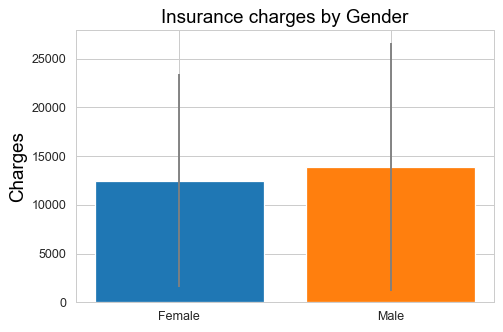

In [32]:
with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('Female', f_charges.mean(), 
           yerr=f_charges.std(), ecolor = 'gray')
    ax.bar('Male', m_charges.mean(), 
           yerr=m_charges.std(), ecolor = 'gray')
    ax.set_ylabel('Charges', fontsize=15, color='black')
    plt.title("Insurance charges by Gender", fontsize=15, color='black')
    plt.show()

In [33]:
insurance.groupby('region').mean().T

region,northeast,northwest,southeast,southwest
age,39.268519,39.219814,38.881215,39.455385
bmi,29.173503,29.179118,33.325442,30.596615
children,1.046296,1.145511,1.055249,1.141538
charges,13406.384516,12303.563574,14467.752658,12346.937377
Total,1.000000,1.000000,1.000000,1.000000


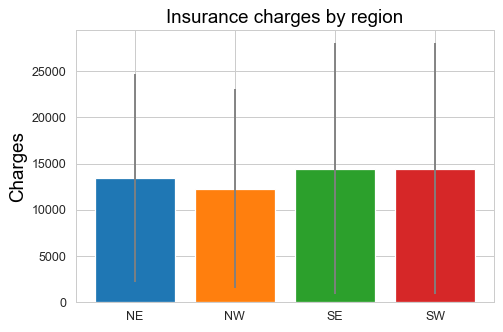

In [34]:
ne_charges = insurance[insurance['region']=='northeast']['charges']
nw_charges = insurance[insurance['region']=='northwest']['charges']
se_charges = insurance[insurance['region']=='southeast']['charges']
sw_charges = insurance[insurance['region']=='southwest']['charges']

with sns.axes_style("whitegrid"):

    fix, ax = plt.subplots(dpi=90)
    ax.bar('NE', ne_charges.mean(), 
           yerr=ne_charges.std(), ecolor = 'gray')
    ax.bar('NW', nw_charges.mean(), 
           yerr=nw_charges.std(), ecolor = 'gray')
    ax.bar('SE', se_charges.mean(),
          yerr=se_charges.std(), ecolor = 'gray')
    ax.bar('SW', se_charges.mean(),
          yerr=se_charges.std(), ecolor = 'gray')
    ax.set_ylabel('Charges', fontsize=15, color='black')
    plt.title("Insurance charges by region", fontsize=15, color='black')
    plt.show()

In [35]:
import statsmodels.stats.multicomp as mc

comp1 = mc.MultiComparison(insurance['charges'], insurance['region'])
tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")
a1[0]

array([[ 1.27334746,  0.20335348],
       [-1.10931248,  0.26768527],
       [ 1.18296611,  0.23725708],
       [-2.29727128,  0.02190486],
       [-0.04942006,  0.96059982],
       [ 2.19602465,  0.02842468]])

### Train test split

In [37]:
X = insurance[['age', 'sex', 'bmi', 'smoker', 'region']]
y = insurance['charges']
print(X.shape)
print(y.shape)

(1334, 5)
(1334,)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=101, shuffle=True)

### Feature engineering

In [42]:
num_attr = X_train.select_dtypes(include='number').columns
cat_attr = X_train.select_dtypes(exclude='number').columns

In [43]:
num_pipeline = Pipeline(
    [
        ('scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, drop='first'))
])

cat_num_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attr),
    ('categorical', cat_pipeline, cat_attr)
])

In [44]:
cat_num_pipeline

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['age', 'bmi'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])

### Modelling

In [45]:
slr_model = Pipeline([
    ('cat_num_pipeline', cat_num_pipeline),
    ('model', LinearRegression())
])

In [46]:
slr_model.fit(X_train,y_train)

Pipeline(steps=[('cat_num_pipeline',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['sex', 'smoker', 'region'], dtype='object'))])),
                ('model', LinearRegression())])

In [47]:
#slr_model.get_params().keys()
coef = slr_model.named_steps['model'].coef_
intercept = slr_model.named_steps['model'].intercept_

y_predict_slr = slr_model.predict(X_test)

r2_slr = r2_score(y_test, y_predict_slr)
mae_slr = mean_absolute_error(y_test,y_predict_slr)
mape_slr = mean_absolute_percentage_error(y_test, y_predict_slr)
rmse_slr = np.sqrt(mean_squared_error(y_test, y_predict_slr))

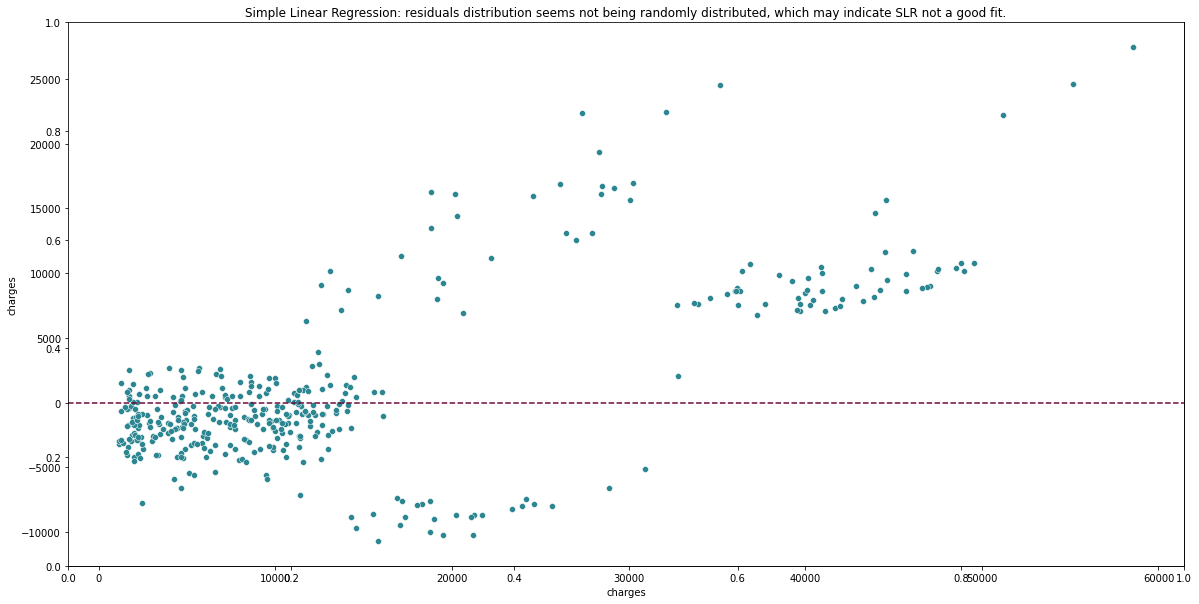

In [148]:
#Residuals distribution plotting to judge, how well the regression line fits the nominal data
test_residuals = y_test - y_predict_slr

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.scatterplot(x=y_test, y=test_residuals, color='#2C8691')
plt.axhline(y=0, ls='--', color='#6E0839')
ax.set_title('Simple Linear Regression: residuals distribution seems not being randomly distributed, which may indicate SLR not a good fit.')
plt.show()

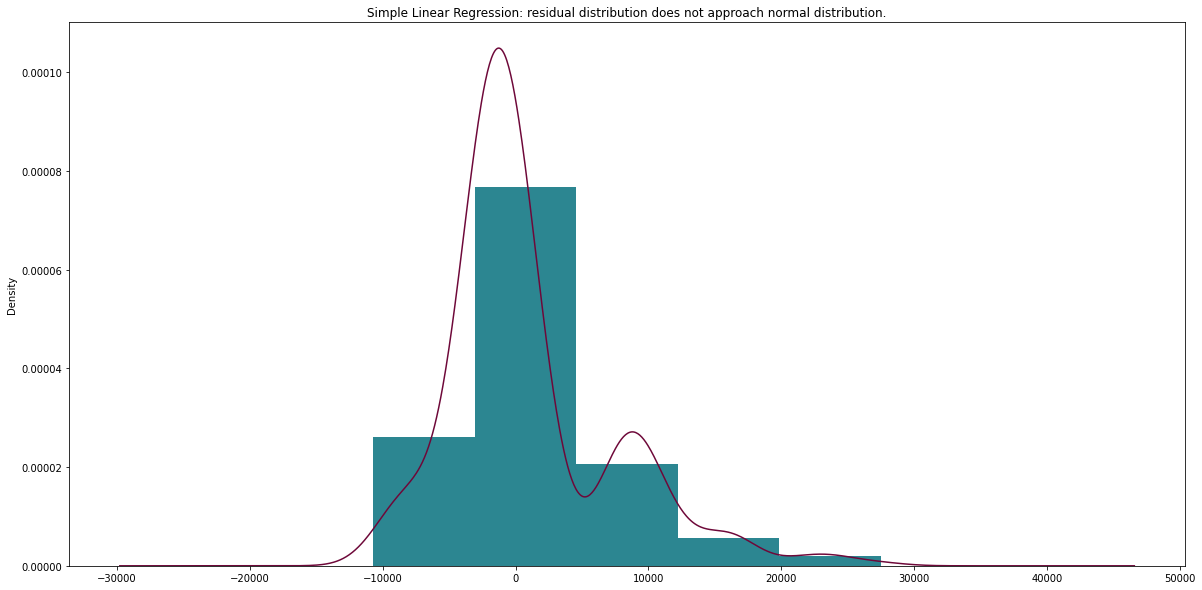

In [149]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(test_residuals,  density=True, bins=5, color='#2C8691')
test_residuals.plot(kind='density', color='#6E0839')
ax.set_title('Simple Linear Regression: residual distribution does not approach normal distribution.')
plt.show();

In [50]:
f_names = slr_model[:-1].get_feature_names_out()
coefs = pd.Series(index=f_names, data=slr_model['model'].coef_).sort_values()
coefs

categorical__region_southwest     -906.114233
categorical__region_northwest     -304.967714
categorical__region_southeast     -186.284181
categorical__sex_male               -3.513951
numerical__bmi                    1763.999114
numerical__age                    3516.697705
categorical__smoker_yes          22288.408906
dtype: float64

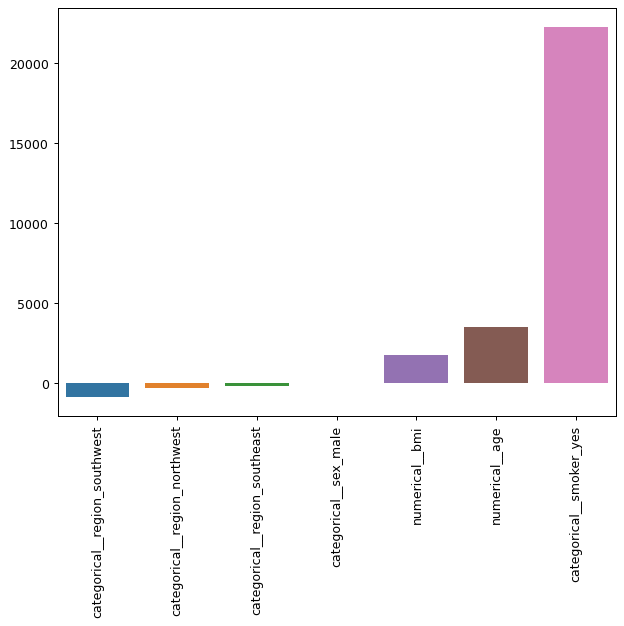

In [51]:
fig, ax = plt.subplots(figsize=(8,6), dpi=90)
sns.barplot(x=coefs.index, y=coefs.values)
plt.xticks(rotation=90)
plt.show()

In [52]:
df = pd.DataFrame({'y_test': y_test,
                  'y_pred': y_predict_slr,
                  'error': test_residuals})

In [53]:
df.sort_values(by='error')

,y_test,y_pred,error
99,15820.69900,26512.438443,-10691.739443
224,19515.54160,29772.055892,-10256.514292
793,21195.81800,31445.038815,-10249.220815
1011,18767.73770,28722.046296,-9954.308596
989,14571.89080,24272.328753,-9700.437953
...,...,...,...
140,27375.90478,5029.147052,22346.757728
936,32108.66282,9638.887206,22469.775614
242,35160.13457,10641.329717,24518.804853
819,55135.40209,30545.260707,24590.141383


In [54]:
print('Simple Linear Regression model results:')
print(f'- regression line intercept: {intercept}')
print(f'- regression line coefficients:\n {coef}')
print(f'How well does model predict the insurance price?')
print(f'- R2 Score: {r2_slr}')
print(f'- MAE: {mae_slr}')
print(f'- MAPE: {mape_slr}')
print(f'- RMSE: {rmse_slr}')
print('-----------------------------------')
print('The most important factors for predictions are:\na) smoking,\nb) age,\nc) bmi.')

Simple Linear Regression model results:
- regression line intercept: 8647.447575219749
- regression line coefficients:
 [ 3.51669770e+03  1.76399911e+03 -3.51395074e+00  2.22884089e+04
 -3.04967714e+02 -1.86284181e+02 -9.06114233e+02]
How well does model predict the insurance price?
- R2 Score: 0.7664215627160118
- MAE: 4327.356415443805
- MAPE: 0.42220176435612344
- RMSE: 6347.596383285422
-----------------------------------
The most important factors for predictions are:
a) smoking,
b) age,
c) bmi.


### Polynomial regression

In [91]:
poly_num_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=3, include_bias=False))
    ])

poly_cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, drop='first'))
])

poly_cat_num_pipeline = ColumnTransformer([
    ('numerical', poly_num_pipeline, num_attr),
    ('categorical', poly_cat_pipeline, cat_attr)
])

In [92]:
plr_model = Pipeline([
    ('cat_num_pipeline', poly_cat_num_pipeline),
    ('model', LinearRegression())
])

In [93]:
plr_model.fit(X_train,y_train)

Pipeline(steps=[('cat_num_pipeline',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly_features',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  Index(['age', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['sex', 'smoker', 'region'], dtype='object'))])),
                ('model', LinearRegression())])

In [94]:
coef = plr_model.named_steps['model'].coef_
intercept = plr_model.named_steps['model'].intercept_

y_predict_plr = plr_model.predict(X_test)

r2_plr = r2_score(y_test, y_predict_plr)
mae_plr = mean_absolute_error(y_test,y_predict_plr)
mape_plr = mean_absolute_percentage_error(y_test, y_predict_plr)
rmse_plr = np.sqrt(mean_squared_error(y_test, y_predict_plr))

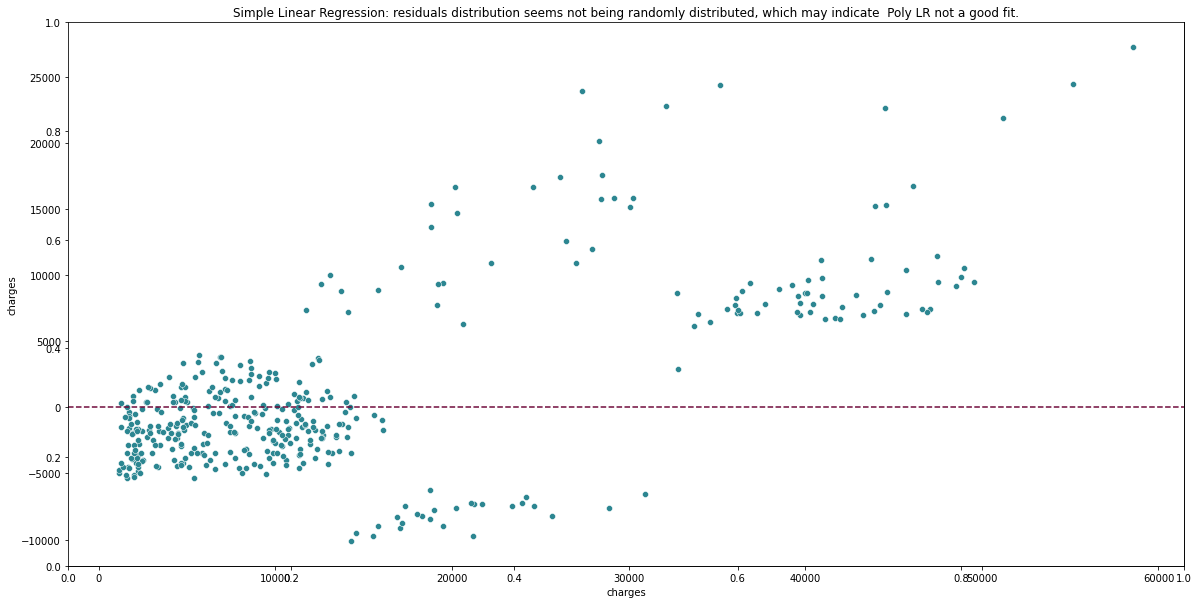

In [150]:
#Residuals distribution plotting to judge, how well the regression line fits the nominal data
test_residuals = y_test - y_predict_plr

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.axes()
sns.scatterplot(x=y_test, y=test_residuals, color='#2C8691')
plt.axhline(y=0, ls='--', color='#6E0839')
ax.set_title('Simple Linear Regression: residuals distribution seems not being randomly distributed, which may indicate  Poly LR not a good fit.')
plt.show()

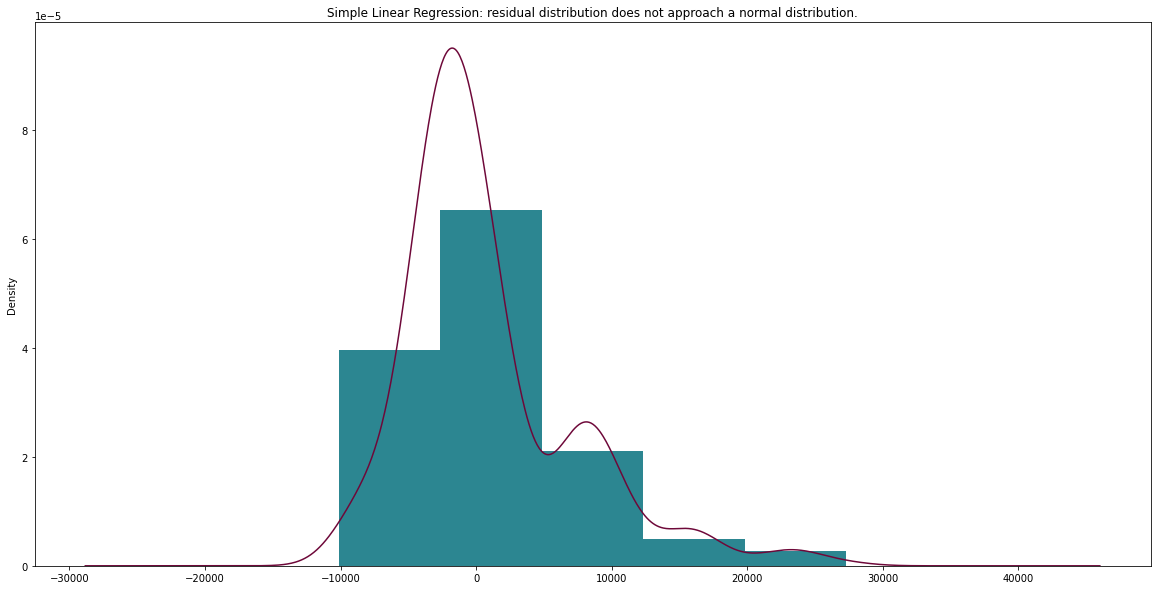

In [151]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(color='gray', which='major',linestyle='--', linewidth=0.5)
ax.hist(test_residuals,  density=True, bins=5, color='#2C8691')
test_residuals.plot(kind='density', color='#6E0839')
ax.set_title('Simple Linear Regression: residual distribution does not approach a normal distribution.')
plt.show();

In [98]:
f_names = plr_model[:-1].get_feature_names_out()
coefs = pd.Series(index=f_names, data=plr_model['model'].coef_).sort_values()
coefs

categorical__region_southwest     -996.867986
categorical__region_northwest     -442.057814
numerical__age^2 bmi              -274.398519
numerical__bmi^3                  -264.981545
numerical__bmi^2                  -253.848383
numerical__age^3                  -157.086554
categorical__region_southeast      -90.454817
numerical__age bmi^2               -85.959058
numerical__age bmi                 -10.468271
categorical__sex_male               -9.240042
numerical__age^2                   787.450182
numerical__bmi                    2864.239843
numerical__age                    3803.769485
categorical__smoker_yes          22288.940726
dtype: float64

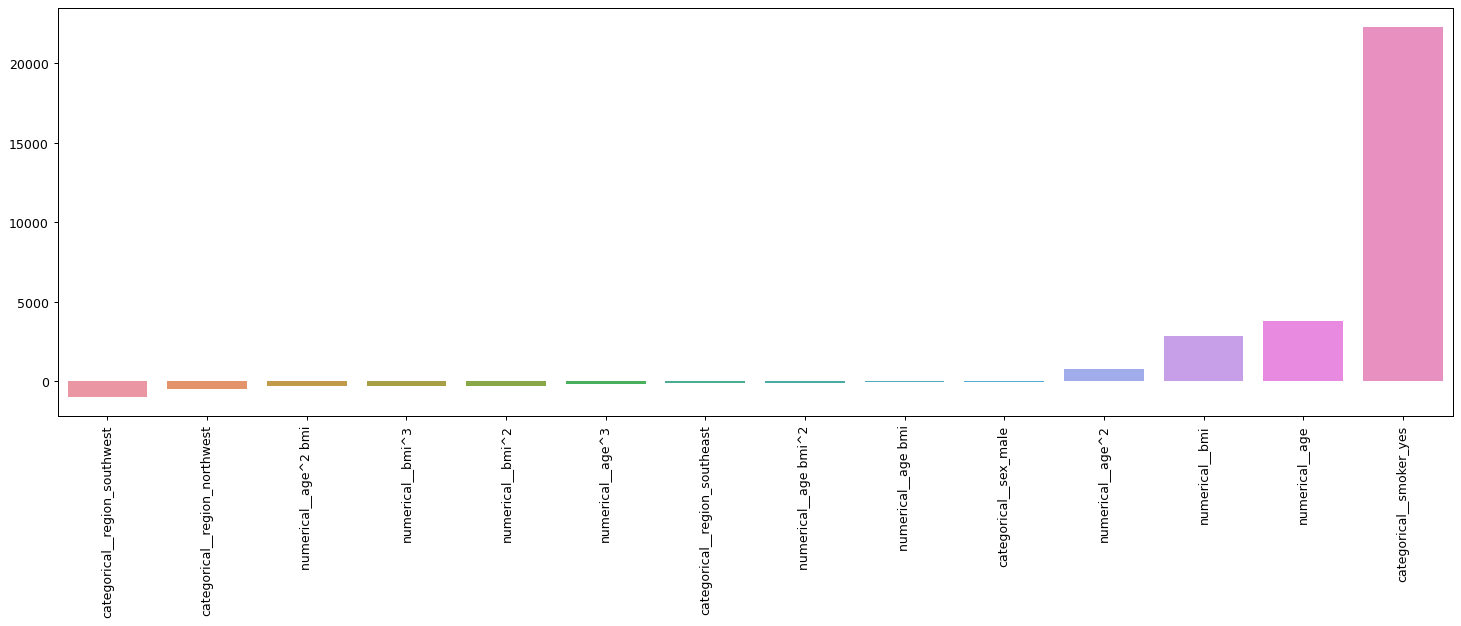

In [99]:
fig, ax = plt.subplots(figsize=(20,6), dpi=90)
sns.barplot(x=coefs.index, y=coefs.values)
plt.xticks(rotation=90)
plt.show()

In [100]:
print('Polynomial Linear Regression model results:')
print(f'- regression line intercept: {intercept}')
print(f'- regression line coefficients:\n {coef}')
print(f'How well does model predict the insurance price?')
print(f'- R2 Score: {r2_plr}')
print(f'- MAE: {mae_plr}')
print(f'- MAPE: {mape_plr}')
print(f'- RMSE: {rmse_plr}')
print('-----------------------------------')
print('The most important factors for predictions are:\na) smoking,\nb) region,\nc) age, d) bmi.')

Polynomial Linear Regression model results:
- regression line intercept: 8253.196270896471
- regression line coefficients:
 [ 3.80376948e+03  2.86423984e+03  7.87450182e+02 -1.04682714e+01
 -2.53848383e+02 -1.57086554e+02 -2.74398519e+02 -8.59590585e+01
 -2.64981545e+02 -9.24004213e+00  2.22889407e+04 -4.42057814e+02
 -9.04548175e+01 -9.96867986e+02]
How well does model predict the insurance price?
- R2 Score: 0.7613509796860894
- MAE: 4502.8609917267295
- MAPE: 0.4833277734012143
- RMSE: 6416.124133193671
-----------------------------------
The most important factors for predictions are:
a) smoking,
b) region,
c) age, d) bmi.


### Decision Tree

In [102]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [103]:
dt_model = Pipeline([
    ('cat_num_pipeline', cat_num_pipeline),
    ('model', DecisionTreeRegressor())
])

In [104]:
dt_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cat_num_pipeline', 'model', 'cat_num_pipeline__n_jobs', 'cat_num_pipeline__remainder', 'cat_num_pipeline__sparse_threshold', 'cat_num_pipeline__transformer_weights', 'cat_num_pipeline__transformers', 'cat_num_pipeline__verbose', 'cat_num_pipeline__verbose_feature_names_out', 'cat_num_pipeline__numerical', 'cat_num_pipeline__categorical', 'cat_num_pipeline__numerical__memory', 'cat_num_pipeline__numerical__steps', 'cat_num_pipeline__numerical__verbose', 'cat_num_pipeline__numerical__scaler', 'cat_num_pipeline__numerical__scaler__copy', 'cat_num_pipeline__numerical__scaler__with_mean', 'cat_num_pipeline__numerical__scaler__with_std', 'cat_num_pipeline__categorical__memory', 'cat_num_pipeline__categorical__steps', 'cat_num_pipeline__categorical__verbose', 'cat_num_pipeline__categorical__ohe', 'cat_num_pipeline__categorical__ohe__categories', 'cat_num_pipeline__categorical__ohe__drop', 'cat_num_pipeline__categorical__ohe__dtype', 'cat_num_pipeline_

In [106]:
dt_param_grid = [
    {
        "model__max_depth": range(1,5),
        "model__min_samples_split": range(10, 20, 10),
        "model__criterion":["squared_error", "friedman_mse"]
    }
]

In [108]:
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, verbose=3)

In [109]:
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__criterion=squared_error, model__max_depth=1, model__min_samples_split=10;, score=0.536 total time=   0.0s
[CV 2/5] END model__criterion=squared_error, model__max_depth=1, model__min_samples_split=10;, score=0.592 total time=   0.0s
[CV 3/5] END model__criterion=squared_error, model__max_depth=1, model__min_samples_split=10;, score=0.677 total time=   0.0s
[CV 4/5] END model__criterion=squared_error, model__max_depth=1, model__min_samples_split=10;, score=0.602 total time=   0.0s
[CV 5/5] END model__criterion=squared_error, model__max_depth=1, model__min_samples_split=10;, score=0.552 total time=   0.0s
[CV 1/5] END model__criterion=squared_error, model__max_depth=2, model__min_samples_split=10;, score=0.770 total time=   0.0s
[CV 2/5] END model__criterion=squared_error, model__max_depth=2, model__min_samples_split=10;, score=0.793 total time=   0.0s
[CV 3/5] END model__criterion=squared_error, model__max_de

GridSearchCV(estimator=Pipeline(steps=[('cat_num_pipeline',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'bmi'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['sex', 'smoker', 'region'], dtype='object'))])),
                                       ('model', DecisionTreeRegressor())]),
             param_grid=[{'model__criterion': ['squared_error', 'friedman_mse'],
                          'model__max_depth': range(1, 5),
                          'model__min_samples_split': range(10, 20, 10)}],
             verbose=3)

In [110]:
dt_grid_search_results = pd.DataFrame(dt_grid_search.cv_results_)
dt_grid_search_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.016811,0.001360,0.008976,0.000631,squared_error,4,10,"{'model__criterion': 'squared_error', 'model__...",0.796202,0.821680,0.898799,0.844158,0.841779,0.840523,0.033853,1
7,0.016850,0.001247,0.008559,0.000615,friedman_mse,4,10,"{'model__criterion': 'friedman_mse', 'model__m...",0.796202,0.821680,0.898799,0.844158,0.841779,0.840523,0.033853,1
2,0.015958,0.000630,0.008577,0.000488,squared_error,3,10,"{'model__criterion': 'squared_error', 'model__...",0.785475,0.815235,0.891635,0.836043,0.839965,0.833670,0.034836,3
6,0.015847,0.001249,0.008681,0.000929,friedman_mse,3,10,"{'model__criterion': 'friedman_mse', 'model__m...",0.785475,0.815235,0.891635,0.836043,0.839965,0.833670,0.034836,3
1,0.016201,0.000409,0.007788,0.000988,squared_error,2,10,"{'model__criterion': 'squared_error', 'model__...",0.770346,0.792819,0.859866,0.828292,0.790936,0.808452,0.031750,5
5,0.015684,0.001165,0.008398,0.000492,friedman_mse,2,10,"{'model__criterion': 'friedman_mse', 'model__m...",0.770346,0.792819,0.859866,0.828292,0.790936,0.808452,0.031750,5
0,0.017591,0.004249,0.008696,0.000593,squared_error,1,10,"{'model__criterion': 'squared_error', 'model__...",0.536394,0.591942,0.676641,0.601716,0.551921,0.591723,0.048901,7
4,0.015594,0.001267,0.007971,0.000015,friedman_mse,1,10,"{'model__criterion': 'friedman_mse', 'model__m...",0.536394,0.591942,0.676641,0.601716,0.551921,0.591723,0.048901,7


In [111]:
dt_grid_search.best_params_

{'model__criterion': 'squared_error',
 'model__max_depth': 4,
 'model__min_samples_split': 10}

In [115]:
dt_best_model = Pipeline(
    [
        ('cat_num_pipeline', cat_num_pipeline),
        ('model', DecisionTreeRegressor(max_depth=4, min_samples_split=10, criterion = 'squared_error'))
    ]
)

dt_best_model.fit(X_train, y_train)

Pipeline(steps=[('cat_num_pipeline',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['sex', 'smoker', 'region'], dtype='object'))])),
                ('model',
                 DecisionTreeRegressor(max_depth=4, min_samples_split=10))])

In [117]:
y_predict_dt = dt_best_model.predict(X_test)

In [118]:
r2_dt = r2_score(y_test, y_predict_dt)
mae_dt = mean_absolute_error(y_test,y_predict_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_predict_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_predict_dt))

In [137]:
f_importances = dt_best_model.named_steps['model'].feature_importances_.flatten()
f_names = dt_best_model[:-1].get_feature_names_out()

In [138]:
feat_importances = pd.Series(index=f_names, data=f_importances).sort_values()
feat_importances

categorical__sex_male            0.000000
categorical__region_northwest    0.000000
categorical__region_southeast    0.000000
categorical__region_southwest    0.000000
numerical__age                   0.131628
numerical__bmi                   0.171711
categorical__smoker_yes          0.696660
dtype: float64

In [139]:
print('Decision Tree model results:')
print(f'How well does model predict the insurance price?')
print(f'- R2 Score: {r2_dt}')
print(f'- MAE: {mae_dt}')
print(f'- MAPE: {mape_dt}')
print(f'- RMSE: {rmse_dt}')
print('-----------------------------------')
print('The most important factors for predictions are:\na) smoking,\nb) bmi,\nc) age')

Decision Tree model results:
How well does model predict the insurance price?
- R2 Score: 0.8679101741429065
- MAE: 2754.365732621226
- MAPE: 0.3408246746452575
- RMSE: 4773.397634513152
-----------------------------------
The most important factors for predictions are:
a) smoking,
b) bmi,
c) age


[Text(0.5, 0.9, 'X[3] <= 0.5\nsquared_error = 127692136.963\nsamples = 933\nvalue = 12789.372'),
 Text(0.25, 0.7, 'X[0] <= 0.526\nsquared_error = 34868396.78\nsamples = 745\nvalue = 8394.983'),
 Text(0.125, 0.5, 'X[0] <= -0.469\nsquared_error = 21588087.06\nsamples = 477\nvalue = 5831.279'),
 Text(0.0625, 0.3, 'X[0] <= -1.18\nsquared_error = 28120205.436\nsamples = 278\nvalue = 4760.291'),
 Text(0.03125, 0.1, 'squared_error = 27117611.58\nsamples = 122\nvalue = 3719.175'),
 Text(0.09375, 0.1, 'squared_error = 27393672.345\nsamples = 156\nvalue = 5574.497'),
 Text(0.1875, 0.3, 'X[0] <= 0.242\nsquared_error = 8621976.364\nsamples = 199\nvalue = 7327.433'),
 Text(0.15625, 0.1, 'squared_error = 8957531.128\nsamples = 142\nvalue = 6761.043'),
 Text(0.21875, 0.1, 'squared_error = 4995913.944\nsamples = 57\nvalue = 8738.439'),
 Text(0.375, 0.5, 'X[0] <= 1.38\nsquared_error = 25986087.47\nsamples = 268\nvalue = 12957.994'),
 Text(0.3125, 0.3, 'X[0] <= 0.882\nsquared_error = 22240594.089\nsampl

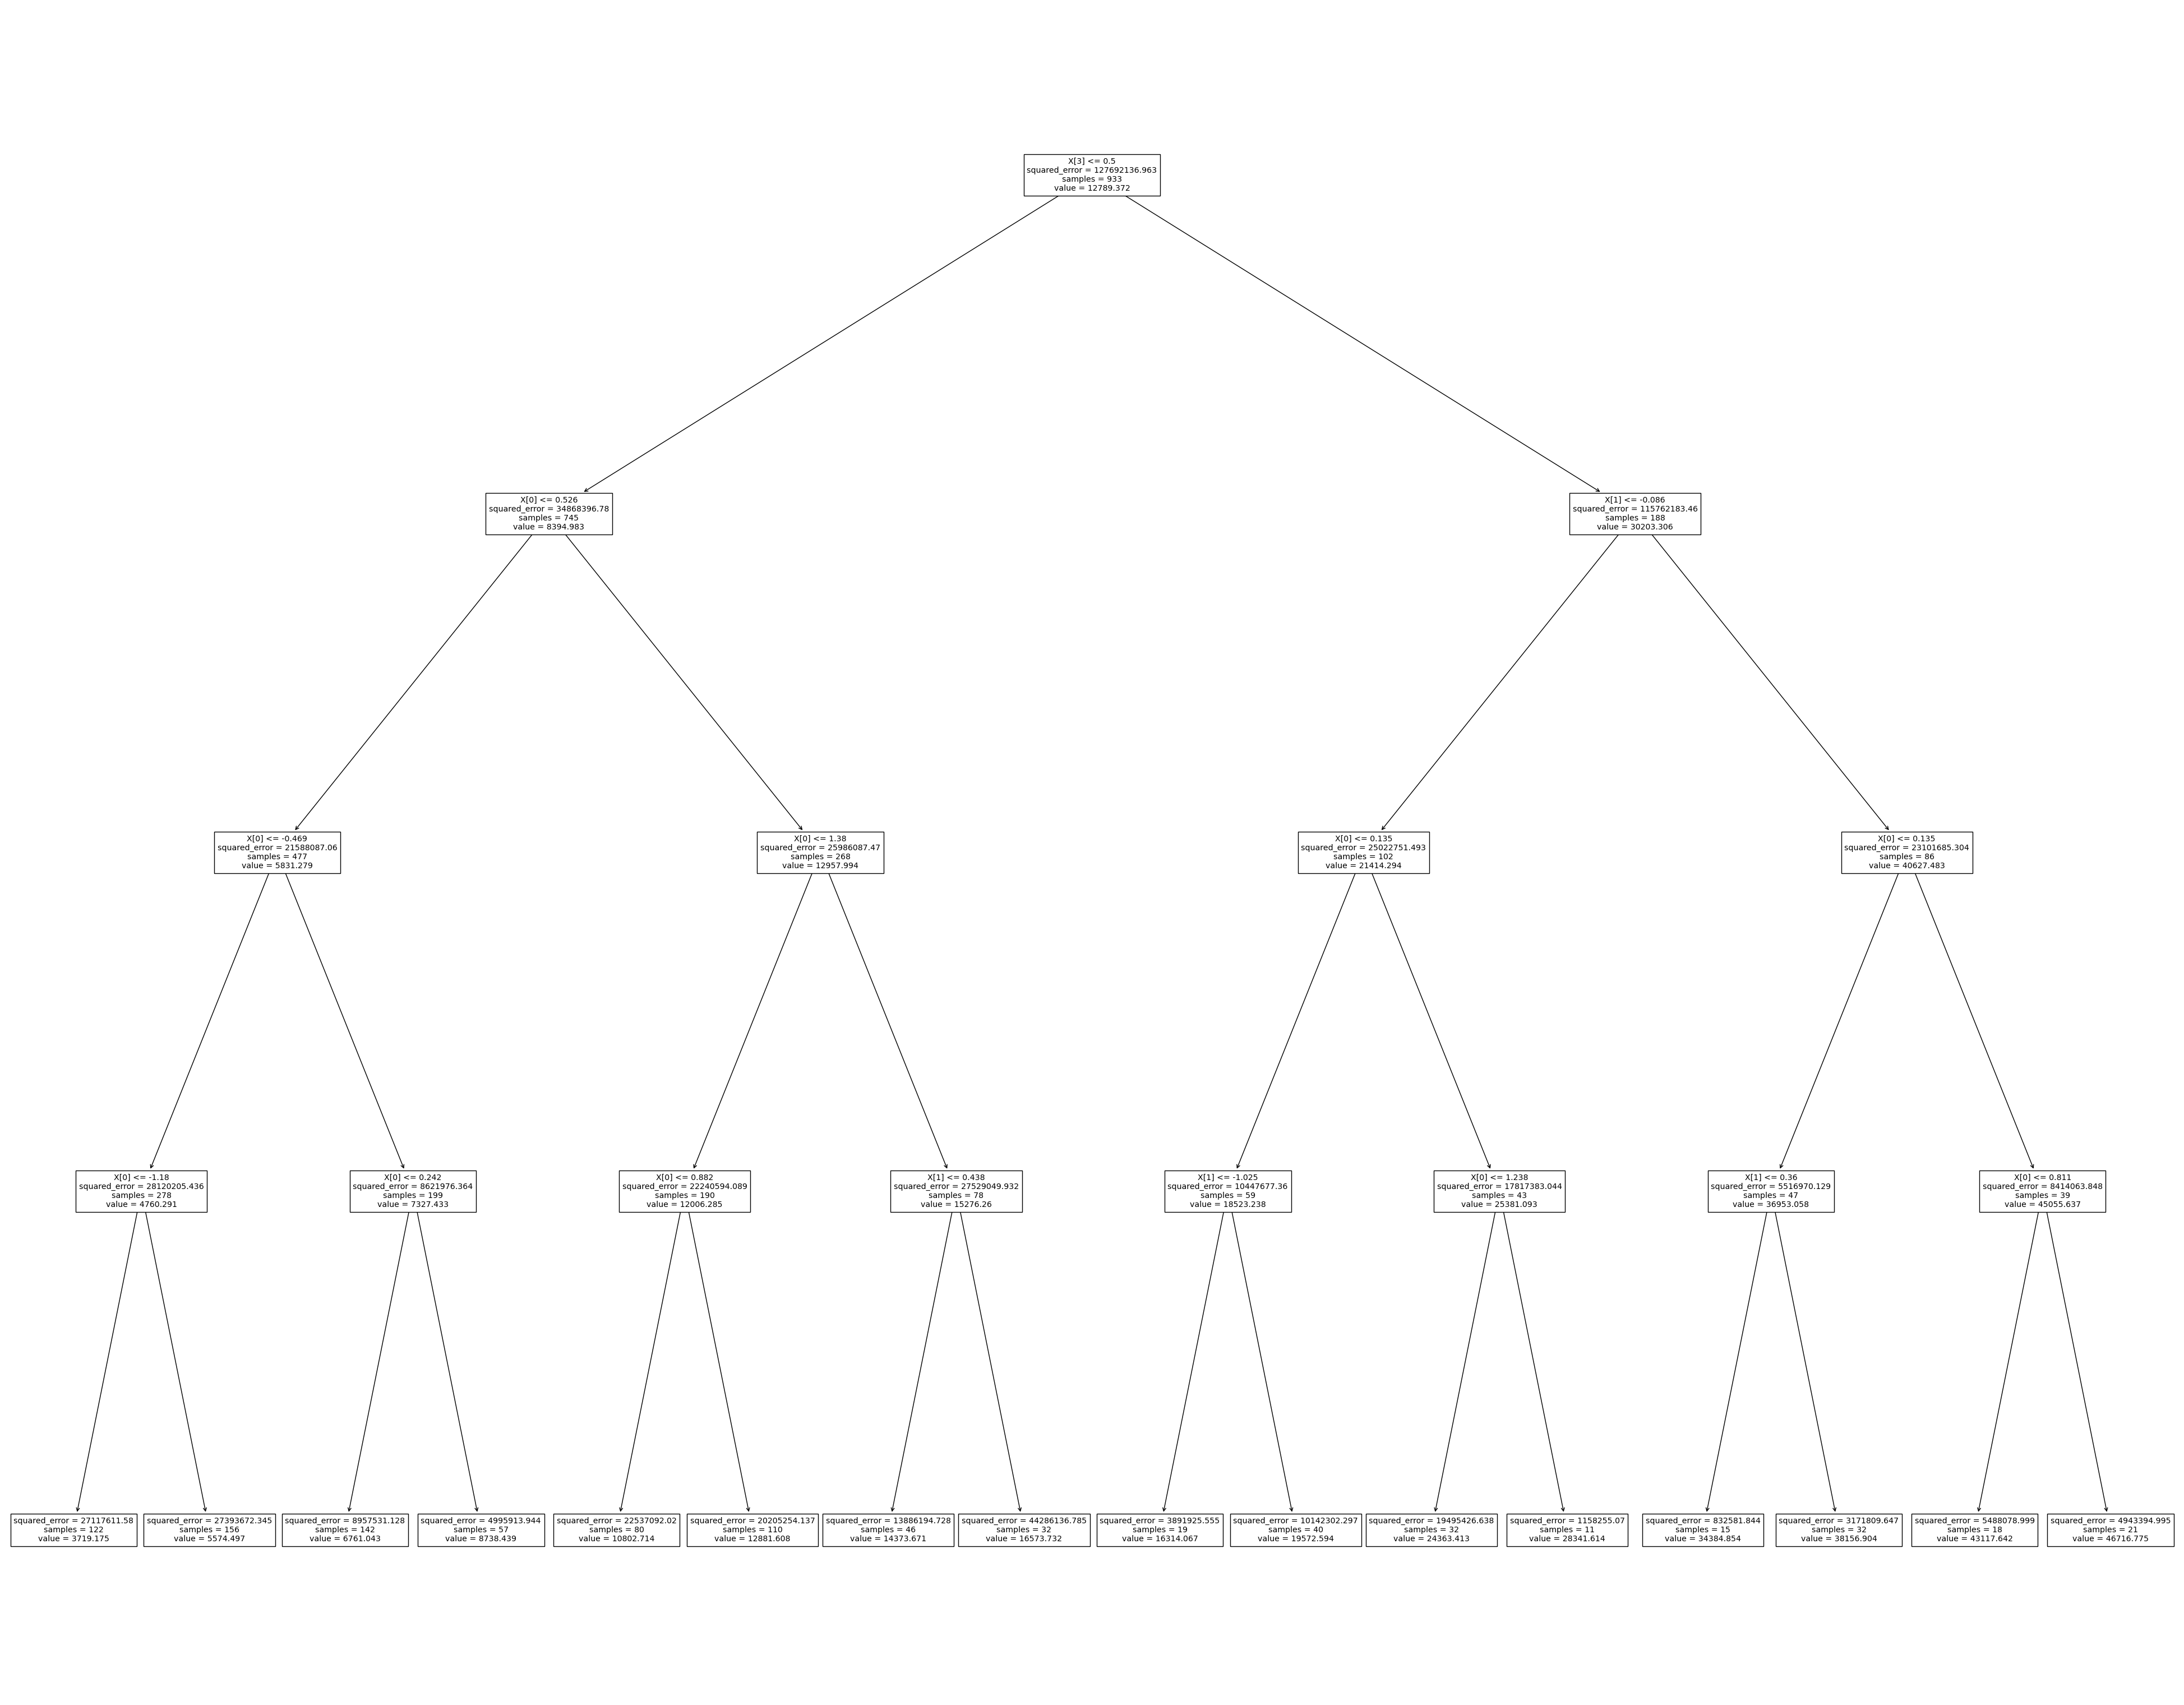

In [147]:
fig = plt.figure(figsize=(50,40), dpi = 100)

plot_tree(dt_best_model['model'])

## Model selection

Comparing to Linear Regression (regardless of the model complexity), the Decision Tree has proven to fit the nominal data set the best.